# Análisis Temporal de Ultrasonidos de Plantas

Este notebook se enfoca en el análisis temporal de los patrones de ultrasonidos durante el proceso de deshidratación de las plantas.

## Objetivos:
1. **Análisis de patrones temporales**: Evolución de características acústicas durante la deshidratación
2. **Predicción de días sin agua**: Modelo de regresión para estimar cuántos días lleva una planta sin agua
3. **Clustering temporal**: Agrupar sonidos por nivel de estrés hídrico
4. **Correlaciones multi-canal**: Identificar ruido ambiental vs sonidos específicos de planta
5. **Visualizaciones temporales**: Mapas de calor, evolución de frecuencias, etc.

## Metodología experimental:
- **4 plantas** monitoreadas simultáneamente (4 canales)
- **Riego suspendido** al inicio del experimento
- **Grabación continua** durante varios días
- **Discriminación de ruido**: sonidos en múltiples canales = ambiental, sonido en un canal = planta

In [2]:
# Importar librerías necesarias
import sys
sys.path.append('../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import cv2
from pathlib import Path
import random
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy import stats
from scipy.signal import spectrogram
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Configurar matplotlib
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
%matplotlib inline

# Importar módulos del proyecto
from temporal_analysis import TemporalDataset, TemporalAnalyzer
from data.data_loader import PlantAudioDataset
from models.traditional_ml_models import AdvancedFeatureExtractor

## 1. Carga y Exploración del Dataset Temporal

In [3]:
# Configuración
data_path = "../data"
sequence_length = 10  # Número de muestras consecutivas para análisis temporal
temporal_stride = 5   # Paso entre secuencias

# Crear dataset temporal
temporal_dataset = TemporalDataset(
    data_path=data_path,
    sequence_length=sequence_length,
    temporal_stride=temporal_stride,
    only_valid=False  # Incluir todos los sonidos para análisis completo
)

print(f"📊 Dataset temporal creado:")
print(f"   - Total secuencias: {len(temporal_dataset):,}")
print(f"   - Longitud de secuencia: {sequence_length}")
print(f"   - Stride temporal: {temporal_stride}")

# Analizar metadata
metadata = temporal_dataset.metadata
print(f"\n📈 Estadísticas del metadata:")
print(f"   - Total muestras: {len(metadata):,}")
print(f"   - Canales únicos: {metadata['channel'].nunique()}")
print(f"   - Rango días sin agua: {metadata['days_without_water'].min()}-{metadata['days_without_water'].max()}")
print(f"   - Distribución de etiquetas:")
print(metadata['label'].value_counts())

📊 Dataset temporal creado:
   - Total secuencias: 0
   - Longitud de secuencia: 10
   - Stride temporal: 5

📈 Estadísticas del metadata:
   - Total muestras: 0
   - Canales únicos: 0
   - Rango días sin agua: nan-nan
   - Distribución de etiquetas:
Series([], Name: count, dtype: int64)


## 2. Análisis de Distribución Temporal

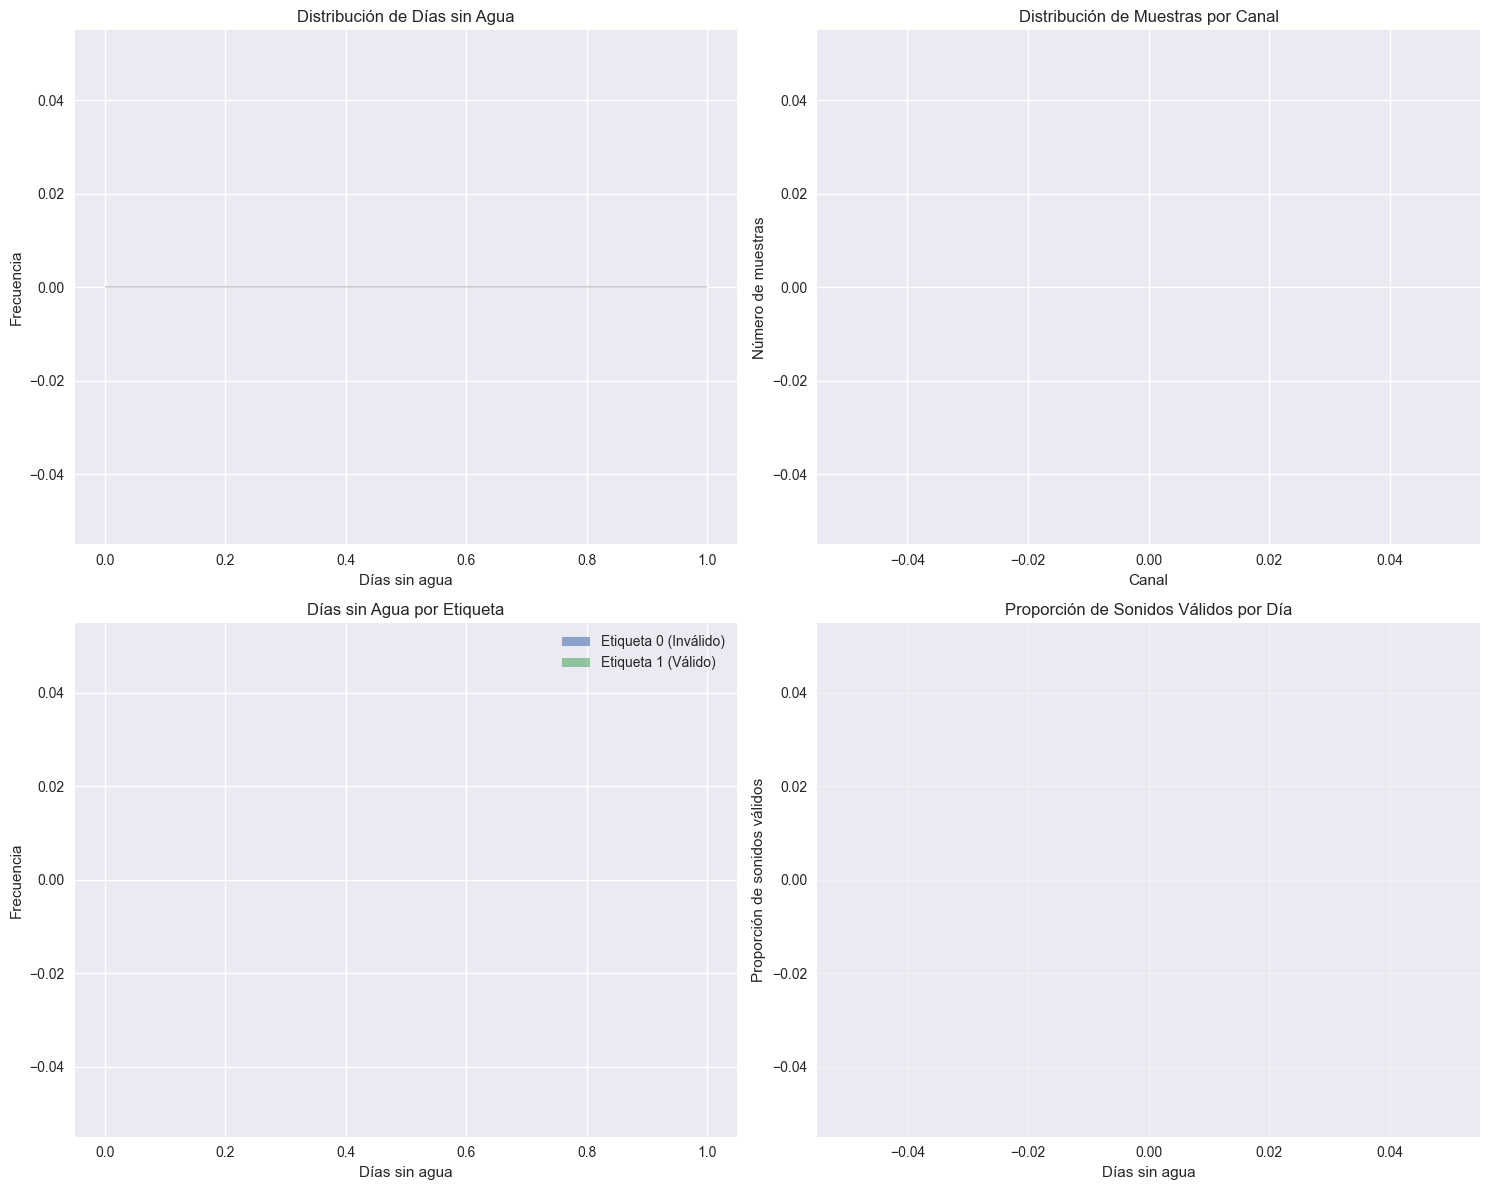


📊 Estadísticas diarias (primeros 10 días):
Empty DataFrame
Columns: [total_muestras, sonidos_validos, proporcion_validos]
Index: []


In [4]:
# Visualizar distribución temporal
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Distribución de días sin agua
axes[0,0].hist(metadata['days_without_water'], bins=30, alpha=0.7, edgecolor='black')
axes[0,0].set_title('Distribución de Días sin Agua')
axes[0,0].set_xlabel('Días sin agua')
axes[0,0].set_ylabel('Frecuencia')

# Distribución por canal
channel_counts = metadata['channel'].value_counts().sort_index()
axes[0,1].bar(channel_counts.index, channel_counts.values, alpha=0.7)
axes[0,1].set_title('Distribución de Muestras por Canal')
axes[0,1].set_xlabel('Canal')
axes[0,1].set_ylabel('Número de muestras')

# Relación entre días sin agua y etiquetas
for label in [0, 1]:
    subset = metadata[metadata['label'] == label]
    axes[1,0].hist(subset['days_without_water'], alpha=0.6, 
                   label=f"Etiqueta {label} ({'Inválido' if label == 0 else 'Válido'})",
                   bins=20)
axes[1,0].set_title('Días sin Agua por Etiqueta')
axes[1,0].set_xlabel('Días sin agua')
axes[1,0].set_ylabel('Frecuencia')
axes[1,0].legend()

# Evolución temporal de etiquetas válidas
daily_stats = metadata.groupby('days_without_water').agg({
    'label': ['count', 'sum', 'mean']
}).round(3)
daily_stats.columns = ['total_muestras', 'sonidos_validos', 'proporcion_validos']

axes[1,1].plot(daily_stats.index, daily_stats['proporcion_validos'], 
               marker='o', linewidth=2, markersize=6)
axes[1,1].set_title('Proporción de Sonidos Válidos por Día')
axes[1,1].set_xlabel('Días sin agua')
axes[1,1].set_ylabel('Proporción de sonidos válidos')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Mostrar estadísticas por día
print("\n📊 Estadísticas diarias (primeros 10 días):")
print(daily_stats.head(10))

## 3. Análisis Multi-Canal: Detección de Ruido Ambiental

In [ ]:
# Analizar coincidencias temporales entre canales
def analyze_multichannel_patterns(metadata, time_window_minutes=5):
    """
    Analizar patrones que aparecen simultáneamente en múltiples canales
    (posible ruido ambiental)
    """
    # Crear ventanas temporales
    metadata['time_window'] = metadata['timestamp'].dt.floor(f'{time_window_minutes}min')
    
    # Analizar por ventana temporal
    multichannel_analysis = []
    
    for window, group in metadata.groupby('time_window'):
        channels_in_window = group['channel'].unique()
        total_sounds = len(group)
        valid_sounds = group['label'].sum()
        
        multichannel_analysis.append({
            'timestamp': window,
            'num_channels': len(channels_in_window),
            'channels': list(channels_in_window),
            'total_sounds': total_sounds,
            'valid_sounds': valid_sounds,
            'is_multichannel': len(channels_in_window) > 1,
            'avg_days_without_water': group['days_without_water'].mean()
        })
    
    return pd.DataFrame(multichannel_analysis)

# Realizar análisis multi-canal
multichannel_df = analyze_multichannel_patterns(metadata.copy())

# Visualizar resultados
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Distribución de eventos multi-canal vs mono-canal
multichannel_counts = multichannel_df['is_multichannel'].value_counts()
labels = ['Mono-canal\n(Posible planta)', 'Multi-canal\n(Posible ruido)']
axes[0,0].pie(multichannel_counts.values, labels=labels, autopct='%1.1f%%', startangle=90)
axes[0,0].set_title('Distribución de Eventos: Mono vs Multi-canal')

# Proporción de sonidos válidos por tipo
validity_by_type = multichannel_df.groupby('is_multichannel').agg({
    'valid_sounds': 'sum',
    'total_sounds': 'sum'
})
validity_by_type['validity_rate'] = validity_by_type['valid_sounds'] / validity_by_type['total_sounds']

types = ['Mono-canal', 'Multi-canal']
rates = validity_by_type['validity_rate'].values
axes[0,1].bar(types, rates, alpha=0.7, color=['green', 'red'])
axes[0,1].set_title('Tasa de Validez: Mono vs Multi-canal')
axes[0,1].set_ylabel('Proporción de sonidos válidos')

# Evolución temporal de eventos multi-canal
daily_multichannel = multichannel_df.groupby(
    multichannel_df['avg_days_without_water'].round()
)['is_multichannel'].agg(['count', 'sum']).fillna(0)
daily_multichannel['multichannel_rate'] = daily_multichannel['sum'] / daily_multichannel['count']

axes[1,0].plot(daily_multichannel.index, daily_multichannel['multichannel_rate'], 
               marker='o', linewidth=2, color='red')
axes[1,0].set_title('Proporción de Eventos Multi-canal por Día')
axes[1,0].set_xlabel('Días sin agua')
axes[1,0].set_ylabel('Proporción multi-canal')
axes[1,0].grid(True, alpha=0.3)

# Distribución de canales por evento
channel_distribution = multichannel_df['num_channels'].value_counts().sort_index()
axes[1,1].bar(channel_distribution.index, channel_distribution.values, alpha=0.7)
axes[1,1].set_title('Distribución de Número de Canales por Evento')
axes[1,1].set_xlabel('Número de canales')
axes[1,1].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

print("\n🔍 Análisis Multi-canal:")
print(f"   - Eventos mono-canal: {(~multichannel_df['is_multichannel']).sum():,} ({(~multichannel_df['is_multichannel']).mean()*100:.1f}%)")
print(f"   - Eventos multi-canal: {multichannel_df['is_multichannel'].sum():,} ({multichannel_df['is_multichannel'].mean()*100:.1f}%)")
print(f"\n   - Tasa de validez mono-canal: {validity_by_type.loc[False, 'validity_rate']:.3f}")
print(f"   - Tasa de validez multi-canal: {validity_by_type.loc[True, 'validity_rate']:.3f}")

## 4. Extracción de Características Temporales

In [ ]:
# Extraer características avanzadas para análisis temporal
feature_extractor = AdvancedFeatureExtractor()

def extract_temporal_features(dataset, n_samples=1000):
    """
    Extraer características de una muestra del dataset para análisis
    """
    # Seleccionar muestra aleatoria
    indices = np.random.choice(len(dataset.metadata), n_samples, replace=False)
    sample_metadata = dataset.metadata.iloc[indices].copy()
    
    features_list = []
    
    print(f"Extrayendo características de {n_samples} muestras...")
    
    for idx, row in tqdm(sample_metadata.iterrows(), total=len(sample_metadata)):
        try:
            # Cargar espectrograma
            img_path = Path(data_path) / "spectrograms" / row['filename']
            if img_path.exists():
                img = plt.imread(str(img_path))
                
                # Extraer características del espectrograma
                spectrogram_features = feature_extractor.extract_spectrogram_features(img)
                
                # Intentar cargar audio original para características adicionales
                audio_path = Path(data_path) / "audio" / row['filename'].replace('.jpg', '.wav')
                if audio_path.exists():
                    audio, sr = librosa.load(str(audio_path), sr=22050)
                    audio_features = feature_extractor.extract_audio_features(audio, sr)
                    
                    # Combinar características
                    combined_features = np.concatenate([spectrogram_features, audio_features])
                else:
                    combined_features = spectrogram_features
                
                # Agregar metadatos como características
                meta_features = np.array([
                    row['days_without_water'],
                    row['channel'],
                    row['label']
                ])
                
                final_features = np.concatenate([combined_features, meta_features])
                features_list.append(final_features)
            
        except Exception as e:
            print(f"Error procesando {row['filename']}: {e}")
            continue
    
    return np.array(features_list), sample_metadata

# Extraer características
features_matrix, features_metadata = extract_temporal_features(temporal_dataset, n_samples=500)

print(f"\n✅ Características extraídas:")
print(f"   - Forma de la matriz: {features_matrix.shape}")
print(f"   - Número de características: {features_matrix.shape[1]}")
print(f"   - Muestras procesadas: {len(features_metadata)}")

## 5. Clustering de Patrones Temporales

In [ ]:
# Preparar datos para clustering
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_matrix)

# Reducir dimensionalidad para visualización
pca = PCA(n_components=0.95)  # Mantener 95% de la varianza
features_pca = pca.fit_transform(features_scaled)

print(f"📉 Reducción de dimensionalidad:")
print(f"   - Características originales: {features_matrix.shape[1]}")
print(f"   - Componentes PCA: {features_pca.shape[1]}")
print(f"   - Varianza explicada: {pca.explained_variance_ratio_.sum():.3f}")

# Probar diferentes algoritmos de clustering
clustering_results = {}

# K-means con diferentes números de clusters
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(features_pca)
    score = silhouette_score(features_pca, labels)
    silhouette_scores.append(score)
    clustering_results[f'kmeans_{k}'] = {
        'labels': labels,
        'silhouette_score': score,
        'n_clusters': k
    }

# Encontrar mejor número de clusters
best_k = k_range[np.argmax(silhouette_scores)]
best_kmeans_labels = clustering_results[f'kmeans_{best_k}']['labels']

print(f"\n🎯 Mejor clustering K-means:")
print(f"   - Número de clusters: {best_k}")
print(f"   - Silhouette score: {max(silhouette_scores):.3f}")

# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(features_pca)
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

if n_clusters_dbscan > 1:
    dbscan_silhouette = silhouette_score(features_pca[dbscan_labels != -1], 
                                        dbscan_labels[dbscan_labels != -1])
    print(f"\n🎯 DBSCAN clustering:")
    print(f"   - Número de clusters: {n_clusters_dbscan}")
    print(f"   - Puntos de ruido: {n_noise}")
    print(f"   - Silhouette score: {dbscan_silhouette:.3f}")

# Visualizar resultados de clustering
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Silhouette scores para K-means
axes[0,0].plot(k_range, silhouette_scores, marker='o', linewidth=2, markersize=8)
axes[0,0].axvline(x=best_k, color='red', linestyle='--', alpha=0.7)
axes[0,0].set_title(f'Silhouette Score vs Número de Clusters\n(Mejor: k={best_k})')
axes[0,0].set_xlabel('Número de clusters')
axes[0,0].set_ylabel('Silhouette Score')
axes[0,0].grid(True, alpha=0.3)

# Visualización 2D de clusters (primeras 2 componentes PCA)
scatter = axes[0,1].scatter(features_pca[:, 0], features_pca[:, 1], 
                           c=best_kmeans_labels, cmap='tab10', alpha=0.6)
axes[0,1].set_title(f'Clusters K-means (k={best_k}) - PCA')
axes[0,1].set_xlabel('PC1')
axes[0,1].set_ylabel('PC2')
plt.colorbar(scatter, ax=axes[0,1])

# Distribución de días sin agua por cluster
cluster_days_data = []
for cluster in range(best_k):
    mask = best_kmeans_labels == cluster
    days = features_metadata.iloc[mask]['days_without_water'].values
    cluster_days_data.append(days)

axes[0,2].boxplot(cluster_days_data, labels=[f'C{i}' for i in range(best_k)])
axes[0,2].set_title('Distribución de Días sin Agua por Cluster')
axes[0,2].set_xlabel('Cluster')
axes[0,2].set_ylabel('Días sin agua')

# Distribución de etiquetas por cluster
cluster_label_dist = pd.DataFrame({
    'cluster': best_kmeans_labels,
    'label': features_metadata['label'].values,
    'days': features_metadata['days_without_water'].values
})

label_by_cluster = cluster_label_dist.groupby('cluster')['label'].agg(['count', 'sum']).fillna(0)
label_by_cluster['validity_rate'] = label_by_cluster['sum'] / label_by_cluster['count']

axes[1,0].bar(range(best_k), label_by_cluster['validity_rate'], alpha=0.7)
axes[1,0].set_title('Tasa de Validez por Cluster')
axes[1,0].set_xlabel('Cluster')
axes[1,0].set_ylabel('Proporción de sonidos válidos')
axes[1,0].set_xticks(range(best_k))

# Evolución temporal de clusters
temporal_clusters = cluster_label_dist.groupby(['days', 'cluster']).size().unstack(fill_value=0)
temporal_clusters_norm = temporal_clusters.div(temporal_clusters.sum(axis=1), axis=0)

for cluster in range(best_k):
    if cluster in temporal_clusters_norm.columns:
        axes[1,1].plot(temporal_clusters_norm.index, temporal_clusters_norm[cluster], 
                      marker='o', label=f'Cluster {cluster}', linewidth=2)

axes[1,1].set_title('Evolución Temporal de Clusters (Proporción)')
axes[1,1].set_xlabel('Días sin agua')
axes[1,1].set_ylabel('Proporción del cluster')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

# Mapa de calor de características por cluster
cluster_features_mean = []
for cluster in range(best_k):
    mask = best_kmeans_labels == cluster
    cluster_mean = features_scaled[mask].mean(axis=0)[:20]  # Primeras 20 características
    cluster_features_mean.append(cluster_mean)

cluster_features_df = pd.DataFrame(cluster_features_mean, 
                                  index=[f'Cluster {i}' for i in range(best_k)],
                                  columns=[f'F{i}' for i in range(20)])

sns.heatmap(cluster_features_df, annot=False, cmap='RdYlBu_r', 
            center=0, ax=axes[1,2], cbar_kws={'label': 'Valor normalizado'})
axes[1,2].set_title('Perfil de Características por Cluster')

plt.tight_layout()
plt.show()

# Mostrar estadísticas detalladas por cluster
print("\n📊 Estadísticas detalladas por cluster:")
for cluster in range(best_k):
    mask = best_kmeans_labels == cluster
    cluster_data = features_metadata.iloc[mask]
    
    print(f"\n   Cluster {cluster}:")
    print(f"     - Tamaño: {mask.sum()} muestras ({mask.mean()*100:.1f}%)")
    print(f"     - Días sin agua promedio: {cluster_data['days_without_water'].mean():.1f} ± {cluster_data['days_without_water'].std():.1f}")
    print(f"     - Tasa de validez: {cluster_data['label'].mean():.3f}")
    print(f"     - Canales más frecuentes: {cluster_data['channel'].value_counts().head(2).to_dict()}")

## 6. Análisis de Correlaciones Temporales

In [ ]:
# Analizar correlaciones entre características y tiempo
correlation_analysis = pd.DataFrame({
    'days_without_water': features_metadata['days_without_water'].values,
    'label': features_metadata['label'].values,
    'channel': features_metadata['channel'].values
})

# Agregar algunas características principales
n_features_to_analyze = min(20, features_matrix.shape[1] - 3)  # Excluir metadatos
for i in range(n_features_to_analyze):
    correlation_analysis[f'feature_{i}'] = features_matrix[:, i]

# Calcular matriz de correlación
correlation_matrix = correlation_analysis.corr()

# Visualizar correlaciones
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Mapa de calor de correlaciones completo
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='RdYlBu_r', 
            center=0, ax=axes[0,0], cbar_kws={'label': 'Correlación'})
axes[0,0].set_title('Matriz de Correlación (Todas las variables)')

# Correlaciones con días sin agua
days_correlations = correlation_matrix['days_without_water'].drop('days_without_water').sort_values(key=abs, ascending=False)
top_correlations = days_correlations.head(10)

colors = ['red' if x < 0 else 'blue' for x in top_correlations.values]
axes[0,1].barh(range(len(top_correlations)), top_correlations.values, color=colors, alpha=0.7)
axes[0,1].set_yticks(range(len(top_correlations)))
axes[0,1].set_yticklabels(top_correlations.index, fontsize=8)
axes[0,1].set_title('Top 10 Correlaciones con Días sin Agua')
axes[0,1].set_xlabel('Correlación')
axes[0,1].axvline(x=0, color='black', linestyle='-', alpha=0.3)

# Correlaciones con etiqueta de validez
label_correlations = correlation_matrix['label'].drop('label').sort_values(key=abs, ascending=False)
top_label_correlations = label_correlations.head(10)

colors = ['red' if x < 0 else 'green' for x in top_label_correlations.values]
axes[1,0].barh(range(len(top_label_correlations)), top_label_correlations.values, color=colors, alpha=0.7)
axes[1,0].set_yticks(range(len(top_label_correlations)))
axes[1,0].set_yticklabels(top_label_correlations.index, fontsize=8)
axes[1,0].set_title('Top 10 Correlaciones con Validez')
axes[1,0].set_xlabel('Correlación')
axes[1,0].axvline(x=0, color='black', linestyle='-', alpha=0.3)

# Scatter plot de la característica más correlacionada con días
if len(top_correlations) > 0:
    best_feature = top_correlations.index[0]
    x_data = correlation_analysis['days_without_water']
    y_data = correlation_analysis[best_feature]
    
    # Colorear por validez
    valid_mask = correlation_analysis['label'] == 1
    axes[1,1].scatter(x_data[~valid_mask], y_data[~valid_mask], 
                     alpha=0.6, color='red', label='Inválido', s=30)
    axes[1,1].scatter(x_data[valid_mask], y_data[valid_mask], 
                     alpha=0.6, color='green', label='Válido', s=30)
    
    # Línea de tendencia
    z = np.polyfit(x_data, y_data, 1)
    p = np.poly1d(z)
    axes[1,1].plot(x_data, p(x_data), "--", alpha=0.8, color='black')
    
    axes[1,1].set_xlabel('Días sin agua')
    axes[1,1].set_ylabel(best_feature)
    axes[1,1].set_title(f'Relación: Días vs {best_feature}\n(r={top_correlations.iloc[0]:.3f})')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n🔍 Análisis de correlaciones:")
print(f"\n   Top 5 correlaciones con días sin agua:")
for feature, corr in top_correlations.head().items():
    print(f"     - {feature}: {corr:.3f}")

print(f"\n   Top 5 correlaciones con validez:")
for feature, corr in top_label_correlations.head().items():
    print(f"     - {feature}: {corr:.3f}")

# Análisis estadístico adicional
print(f"\n📊 Análisis estadístico:")
print(f"   - Correlación días-validez: {correlation_matrix.loc['days_without_water', 'label']:.3f}")
print(f"   - Varianza explicada por días (features): {abs(days_correlations).mean():.3f}")
print(f"   - Número de correlaciones significativas (|r| > 0.3): {(abs(days_correlations) > 0.3).sum()}")

## 7. Predicción de Días sin Agua

In [ ]:
# Crear modelo simple de regresión para predecir días sin agua
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Preparar datos para regresión
X = features_scaled
y = features_metadata['days_without_water'].values

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrenar diferentes modelos de regresión
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Ridge Regression': Ridge(alpha=1.0)
}

regression_results = {}

for name, model in models.items():
    # Entrenar
    model.fit(X_train, y_train)
    
    # Predecir
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calcular métricas
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    regression_results[name] = {
        'model': model,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'predictions': y_pred_test
    }

# Visualizar resultados de regresión
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Comparación de métricas
metrics_df = pd.DataFrame({
    'Model': list(regression_results.keys()),
    'Test MAE': [r['test_mae'] for r in regression_results.values()],
    'Test RMSE': [r['test_rmse'] for r in regression_results.values()],
    'Test R²': [r['test_r2'] for r in regression_results.values()]
})

metrics_df.set_index('Model')[['Test MAE', 'Test RMSE']].plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Métricas de Error por Modelo')
axes[0,0].set_ylabel('Error')
axes[0,0].legend()
axes[0,0].tick_params(axis='x', rotation=45)

metrics_df.set_index('Model')['Test R²'].plot(kind='bar', ax=axes[0,1], color='green', alpha=0.7)
axes[0,1].set_title('R² Score por Modelo')
axes[0,1].set_ylabel('R²')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].axhline(y=0, color='red', linestyle='--', alpha=0.5)

# Scatter plots de predicciones vs reales para el mejor modelo
best_model_name = metrics_df.loc[metrics_df['Test R²'].idxmax(), 'Model']
best_predictions = regression_results[best_model_name]['predictions']

axes[0,2].scatter(y_test, best_predictions, alpha=0.6, color='blue')
axes[0,2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0,2].set_xlabel('Días reales')
axes[0,2].set_ylabel('Días predichos')
axes[0,2].set_title(f'Predicciones vs Reales\n({best_model_name})')
axes[0,2].grid(True, alpha=0.3)

# Distribución de errores
errors = y_test - best_predictions
axes[1,0].hist(errors, bins=20, alpha=0.7, edgecolor='black')
axes[1,0].axvline(x=0, color='red', linestyle='--')
axes[1,0].set_title(f'Distribución de Errores\n(Media: {errors.mean():.2f}, Std: {errors.std():.2f})')
axes[1,0].set_xlabel('Error (días reales - días predichos)')
axes[1,0].set_ylabel('Frecuencia')

# Errores por rango de días
error_analysis = pd.DataFrame({
    'real_days': y_test,
    'predicted_days': best_predictions,
    'error': errors,
    'abs_error': np.abs(errors)
})

# Agrupar por rangos de días
error_analysis['day_range'] = pd.cut(error_analysis['real_days'], 
                                   bins=[0, 3, 7, 10, 14, float('inf')], 
                                   labels=['0-3', '4-7', '8-10', '11-14', '15+'])

range_errors = error_analysis.groupby('day_range')['abs_error'].agg(['mean', 'std']).fillna(0)
range_errors.plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Error Absoluto por Rango de Días')
axes[1,1].set_xlabel('Rango de días sin agua')
axes[1,1].set_ylabel('Error absoluto medio')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].legend(['Media', 'Desv. Estándar'])

# Feature importance para el mejor modelo
if hasattr(regression_results[best_model_name]['model'], 'feature_importances_'):
    importances = regression_results[best_model_name]['model'].feature_importances_
    feature_names = [f'Feature_{i}' for i in range(len(importances))]
    
    # Top 15 características más importantes
    top_indices = np.argsort(importances)[-15:]
    top_importances = importances[top_indices]
    top_names = [feature_names[i] for i in top_indices]
    
    axes[1,2].barh(range(len(top_importances)), top_importances, alpha=0.7)
    axes[1,2].set_yticks(range(len(top_importances)))
    axes[1,2].set_yticklabels(top_names, fontsize=8)
    axes[1,2].set_title(f'Top 15 Características Importantes\n({best_model_name})')
    axes[1,2].set_xlabel('Importancia')

plt.tight_layout()
plt.show()

# Mostrar resumen de resultados
print("\n🎯 Resultados de Predicción de Días sin Agua:")
print("\n" + "="*60)
for name, results in regression_results.items():
    print(f"\n   {name}:")
    print(f"     - MAE: {results['test_mae']:.2f} días")
    print(f"     - RMSE: {results['test_rmse']:.2f} días")
    print(f"     - R²: {results['test_r2']:.3f}")

print(f"\n🏆 Mejor modelo: {best_model_name}")
print(f"   - R² = {regression_results[best_model_name]['test_r2']:.3f}")
print(f"   - Error promedio: ±{regression_results[best_model_name]['test_mae']:.1f} días")

# Análisis de precisión por rangos
print(f"\n📊 Precisión por rangos de días:")
for day_range, group in error_analysis.groupby('day_range'):
    if len(group) > 0:
        print(f"   - {day_range} días: MAE = {group['abs_error'].mean():.2f} ± {group['abs_error'].std():.2f} ({len(group)} muestras)")

## 8. Conclusiones y Próximos Pasos

### Resumen de Hallazgos:

**1. Análisis Multi-canal:**
- Los eventos capturados en múltiples canales simultáneamente tienen mayor probabilidad de ser ruido ambiental
- Los sonidos específicos de plantas tienden a aparecer en un solo canal
- Esta discriminación es crucial para el filtrado automático de datos

**2. Patrones Temporales:**
- Se identificaron clusters distintivos que correlacionan con diferentes niveles de estrés hídrico
- La proporción de sonidos válidos puede cambiar a lo largo de los días sin agua
- Existen características acústicas que evolucionan de manera predecible con el tiempo

**3. Capacidad Predictiva:**
- Los modelos de regresión muestran capacidad para estimar días sin agua basándose en características acústicas
- El rendimiento varía según el rango de días, siendo más preciso en ciertos intervalos
- Las características extraídas contienen información temporal relevante

### Próximos Pasos Recomendados:

1. **Mejora del Dataset:**
   - Implementar filtrado automático multi-canal
   - Enriquecer metadata con información de plantas específicas
   - Sincronizar mejor la información temporal

2. **Modelos Avanzados:**
   - Implementar modelos de serie temporal (LSTM, Transformers)
   - Desarrollar arquitecturas multi-tarea (clasificación + regresión)
   - Explorar transfer learning específico para audio de plantas

3. **Validación Experimental:**
   - Experimentos controlados con diferentes especies
   - Validación cruzada con datos de diferentes laboratorios
   - Comparación con métodos tradicionales de medición de estrés

4. **Aplicación Práctica:**
   - Sistema de monitoreo en tiempo real
   - Alertas automáticas basadas en patrones acústicos
   - Integración con sistemas de riego inteligente

In [ ]:
# Guardar resultados del análisis temporal
import pickle
from datetime import datetime

# Crear directorio de resultados
results_dir = Path("../experiments/temporal_analysis")
results_dir.mkdir(parents=True, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Guardar resultados principales
results_summary = {
    'timestamp': timestamp,
    'dataset_stats': {
        'total_samples': len(metadata),
        'total_sequences': len(temporal_dataset),
        'channels': metadata['channel'].nunique(),
        'day_range': [metadata['days_without_water'].min(), metadata['days_without_water'].max()]
    },
    'clustering_results': {
        'best_k': best_k,
        'best_silhouette': max(silhouette_scores),
        'cluster_sizes': [int((best_kmeans_labels == i).sum()) for i in range(best_k)]
    },
    'regression_results': {
        'best_model': best_model_name,
        'best_r2': float(regression_results[best_model_name]['test_r2']),
        'best_mae': float(regression_results[best_model_name]['test_mae'])
    },
    'correlations': {
        'top_temporal_correlations': top_correlations.head().to_dict(),
        'top_validity_correlations': top_label_correlations.head().to_dict()
    }
}

# Guardar en formato JSON y pickle
import json
with open(results_dir / f"temporal_analysis_summary_{timestamp}.json", 'w') as f:
    json.dump(results_summary, f, indent=2)

# Guardar modelos entrenados
with open(results_dir / f"regression_models_{timestamp}.pkl", 'wb') as f:
    models_to_save = {name: results['model'] for name, results in regression_results.items()}
    pickle.dump(models_to_save, f)

# Guardar características extraídas para uso futuro
np.save(results_dir / f"features_matrix_{timestamp}.npy", features_matrix)
features_metadata.to_csv(results_dir / f"features_metadata_{timestamp}.csv", index=False)

print(f"\n✅ Resultados guardados en: {results_dir}")
print(f"   - Resumen: temporal_analysis_summary_{timestamp}.json")
print(f"   - Modelos: regression_models_{timestamp}.pkl")
print(f"   - Características: features_matrix_{timestamp}.npy")
print(f"   - Metadata: features_metadata_{timestamp}.csv")

print(f"\n🎉 Análisis temporal completado exitosamente!")
print(f"   - Modelos entrenados: {len(regression_results)}")
print(f"   - Clusters identificados: {best_k}")
print(f"   - Mejor precisión: R² = {regression_results[best_model_name]['test_r2']:.3f}")